# Experiment with UNet Training

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import xarray as xr
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import draw_bounding_boxes
from xarray import DataArray

from rattlinbog.estimators.apply import apply
from rattlinbog.estimators.wetland_classifier import WetlandClassifier
from rattlinbog.io_xarray.store_as_compressed_zarr import store_as_compressed_zarr
from rattlinbog.pipeline.factory_functions import make_validation_log_cfg
from rattlinbog.pipeline.train import train
from rattlinbog.sampling.sample_patches_from_dataset import SamplingConfig, make_balanced_sample_indices_for
from rattlinbog.th_extensions.nn.unet import UNet
from rattlinbog.th_extensions.utils.dataset_splitters import GROUND_TRUTH_KEY, \
    PARAMS_KEY

RESAMPLE = False

## Data Investigation

In [2]:
valid_ds = xr.open_zarr(
    "/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E048N021T3/SIG0-HPAR-MASK____CORINE-INLAND-MARSHES-ROI-0-0-15000-15000_E048N021T3_EU020M__.zarr")
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
valid_ds = valid_ds.sel(parameter=param_selection)

In [3]:
valid_ds = valid_ds.load()

In [7]:
# y=slice(2399606, 2343027), x=slice(4847841, 4919127) north germany
# y=slice(1300000, 1200000), x=slice(6200000, 6300000) danube delta
valid_selection = valid_ds.sel(y=slice(2400000, 2343000), x=slice(4848000, 4920000))
valid_selection

<xarray.Dataset>
Dimensions:       (y: 2850, x: 3600, parameter: 3)
Coordinates:
    band          int64 ...
  * parameter     (parameter) <U14 'SIG0-HPAR-PHS' ... 'SIG0-HPAR-M0'
  * x             (x) float64 4.848e+06 4.848e+06 ... 4.92e+06 4.92e+06
  * y             (y) float64 2.4e+06 2.4e+06 2.4e+06 ... 2.343e+06 2.343e+06
Data variables:
    ground_truth  (y, x) float32 dask.array<chunksize=(500, 100), meta=np.ndarray>
    params        (parameter, y, x) float32 dask.array<chunksize=(3, 500, 100), meta=np.ndarray>
    spatial_ref   int64 ...

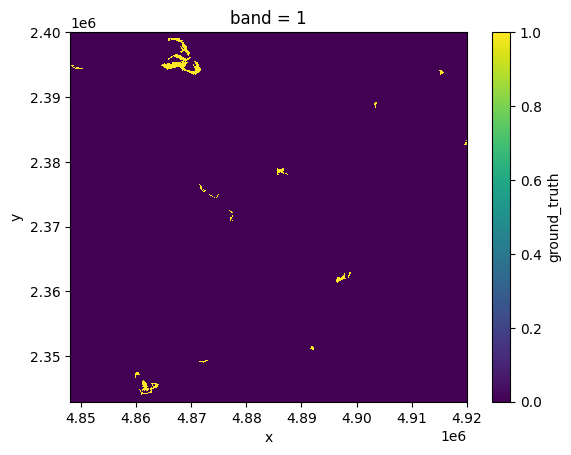

In [8]:
valid_selection[GROUND_TRUTH_KEY].plot.imshow()

## Test Model

### hparam model test

In [2]:
test_ds = xr.open_zarr(
    "/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E060N012T3/SIG0-HPAR-MASK____CORINE-INLAND-MARSHES-ROI-0-0-15000-15000_E060N012T3_EU020M__.zarr")
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
test_ds = test_ds.sel(parameter=param_selection)

In [3]:
test_ds = test_ds.sel(y=slice(1300000, 1200000), x=slice(6200000, 6300000))

In [4]:
def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)


def preprocess_rgb_comp(x):
    o = x.copy()
    o[0, ...] = normalize(x[0], -np.pi, np.pi)
    o[1, ...] = normalize(np.clip((10 ** (x[1] / 10.0)), 1, 1.5), 1.0, 1.5)
    o[2, ...] = normalize(np.clip(x[2], -25, -8), -25, -8)
    return o


test_ds[PARAMS_KEY] = test_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=test_ds[PARAMS_KEY])

In [5]:
test_ds = test_ds.persist()

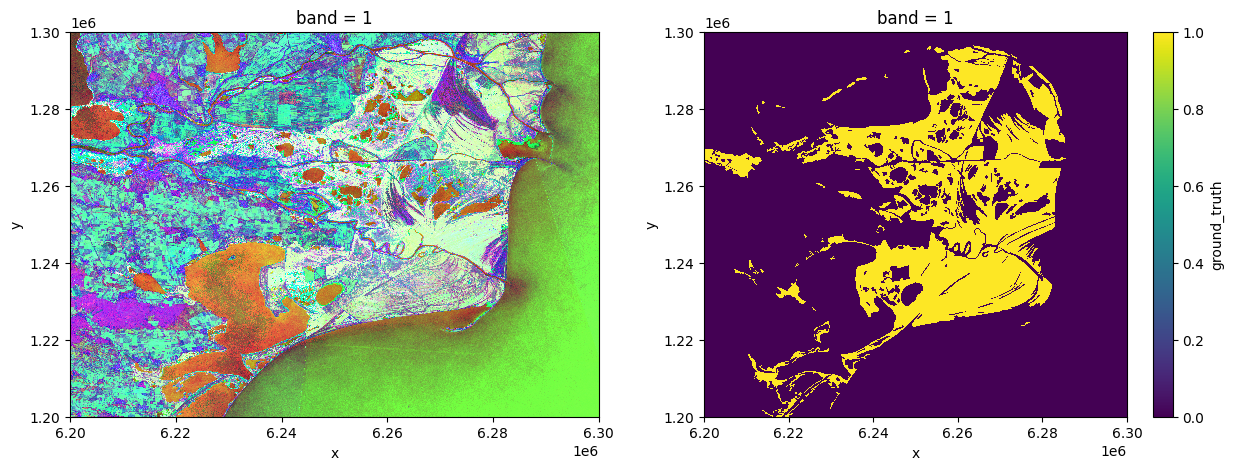

In [6]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
test_ds[PARAMS_KEY].plot.imshow(ax=axes[0])
test_ds[GROUND_TRUTH_KEY].plot(ax=axes[1])
plt.draw()

#### Load and test model

In [7]:
estimator = WetlandClassifier.from_snapshot(Path('/data/wetland/models/hparam/2023-05-14_22-17-18/WetlandClassifier-F1-best.pt'), batch_size=16)

In [8]:
estimate = apply(estimator).to(test_ds['params'])

In [9]:
estimate = estimate.load()

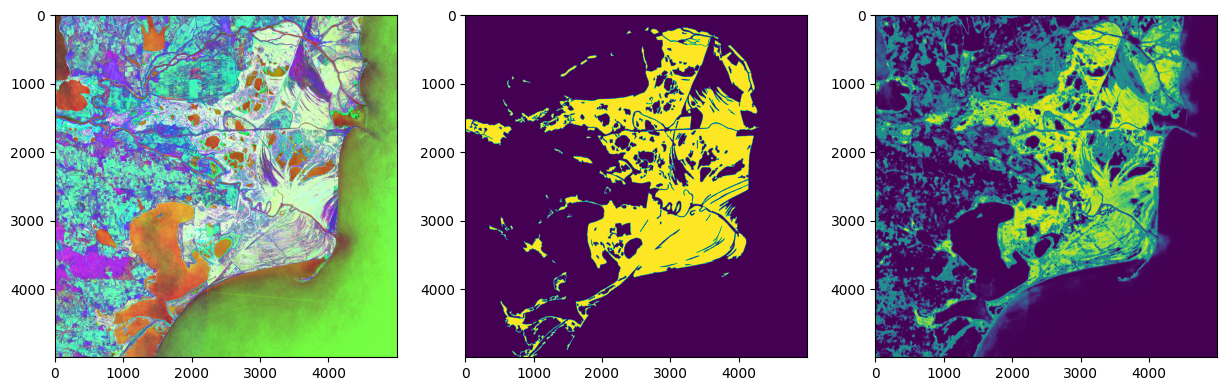

In [10]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(test_ds[PARAMS_KEY].values.transpose((1, 2, 0)))
axes[1].imshow(test_ds[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0])
plt.draw()

In [12]:
scores = estimator._score_estimate(estimate.values, test_ds[GROUND_TRUTH_KEY].values)
scores

{'TPR': 0.7943727821018695,
 'TNR': 0.9263236851560425,
 'FPR': 0.07367631484395755,
 'FNR': 0.20562721789813054,
 'PPV': 0.74580085,
 'F1': 0.7693209,
 'BA': 0.860348233628956}

## Export Estimates

In [12]:
valid_estimate = estimate.rio.write_transform(valid_ds[GROUND_TRUTH_KEY].rio.transform())
valid_estimate = valid_estimate.rio.write_crs(valid_ds.spatial_ref.attrs['crs_wkt'])
valid_estimate = valid_estimate.where(valid_estimate>0.1, 0)
valid_estimate.rio.write_nodata(0, inplace=True)
valid_estimate[0].rio.to_raster("/tmp/valid-estimate.tif")

In [14]:
estimate_train = apply(estimator).to(train_ds['params'])

In [15]:
train_estimate = estimate_train.rio.write_transform(train_ds[GROUND_TRUTH_KEY].rio.transform())
train_estimate = train_estimate.rio.write_crs(train_ds.spatial_ref.attrs['crs_wkt']).load()

In [47]:
train_estimate_mask = train_estimate.where(train_estimate>0.1, 0)
train_estimate_mask = train_estimate_mask.rio.set_encoding(dict(dtype='uint8', _FillValue=255))
train_estimate_mask[0].rio.to_raster("/tmp/train-estimate-mask.tif", compress='ZSTD')

In [16]:
train_estimate_prob = train_estimate.rio.set_encoding(dict(scale_factor=0.01, dtype='int8', _FillValue=127))
train_estimate_prob[0].rio.to_raster("/tmp/train-estimate-prob-incomplete.tif", compress='ZSTD')

In [19]:
train_ds[GROUND_TRUTH_KEY].rio.to_raster("/tmp/train-mask-incomplete.tif", compress='ZSTD')

In [24]:
wetland_rgb_ds = wetland_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=wetland_ds[PARAMS_KEY])

In [26]:
wetland_rgb_out = wetland_rgb_ds.rio.write_transform(wetland_ds[GROUND_TRUTH_KEY].rio.transform())
wetland_rgb_out = wetland_rgb_out.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
wetland_rgb_out = wetland_rgb_out.rio.set_encoding(dict(scale_factor=0.01, dtype='uint8', _FillValue=255))
wetland_rgb_out.rio.to_raster('/tmp/rgb-composite.tif', compress='ZSTD')

In [16]:
estimate_all = apply(estimator).to(wetland_rgb_ds)

In [17]:
estimate_all = estimate_all.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
estimate_all = estimate_all.where(estimate_all>0.1, 0)
estimate_all.rio.write_nodata(0, inplace=True)
estimate_all[0].rio.to_raster("/tmp/all-estimate.tif")